In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')


pd.options.display.float_format = "{:,.2f}".format

df2018 = pd.read_csv('DADOS/MICRODADOS_ENEM_2018.csv',
                     nrows = 100000, sep = ';', encoding = 'ISO-8859-1')


df2018.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,180008202043,2018,5300108,Brasília,53,DF,44.00,M,1.00,1,...,A,A,A,A,A,A,A,A,B,A
1,180007197856,2018,2111102,São João dos Patos,21,MA,23.00,F,0.00,3,...,A,B,A,A,B,A,A,A,A,A
2,180008517434,2018,3530607,Mogi das Cruzes,35,SP,23.00,F,0.00,1,...,A,B,A,A,B,B,B,B,A,A
3,180007661228,2018,2916401,Itapetinga,29,BA,26.00,F,0.00,3,...,A,B,B,A,C,A,B,B,A,A
4,180008787987,2018,2918100,Jeremoabo,29,BA,20.00,M,0.00,0,...,A,B,A,A,B,A,B,B,B,A


Let's drop the irrelevant columns. NU_INSCRIÇAO and NU_ANO are some of them.
Also 'CO_MUNICIPIO_RESIDENCIA' is equivalent to 'NO_MUNICIPIO_RESIDENCIA'
and 'CO_UF_RESIDENCIA' is equivalent to 'SG_UF_RESIDENCIA'.

In [2]:
cols = ['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'CO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'TP_NACIONALIDADE', 'NO_MUNICIPIO_NASCIMENTO', 'SG_UF_NASCIMENTO']

df2018 = df2018.drop(columns = cols)


#df2018.NO_MUNICIPIO_RESIDENCIA.unique().shape

df2018.head()

,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,Brasília,DF,44.00,M,1.00,1,2,0,2,1.00,...,A,A,A,A,A,A,A,A,B,A
1,São João dos Patos,MA,23.00,F,0.00,3,1,5,1,1.00,...,A,B,A,A,B,A,A,A,A,A
2,Mogi das Cruzes,SP,23.00,F,0.00,1,1,3,1,3.00,...,A,B,A,A,B,B,B,B,A,A
3,Itapetinga,BA,26.00,F,0.00,3,1,8,1,1.00,...,A,B,B,A,C,A,B,B,A,A
4,Jeremoabo,BA,20.00,M,0.00,0,2,0,2,1.00,...,A,B,A,A,B,A,B,B,B,A


For the model prediction, we are also not interested in information regarding the answers
given by the students at the answer card. Nor the test informations, like the test number and so on

In [3]:
cols = ['CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'TX_GABARITO_CN',
        'TX_GABARITO_CH', 'TX_GABARITO_LC','TX_GABARITO_MT','TP_STATUS_REDACAO',
        'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 
        'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']

df2018 = df2018.drop(columns = cols)

In [4]:
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 0]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 1]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 2]))

## Removing those which didn't show up for the test

df2018 = df2018[(df2018.TP_PRESENCA_CN == 1) & (df2018.TP_PRESENCA_CH == 1) & (df2018.TP_PRESENCA_LC == 1) & (df2018.TP_PRESENCA_MT == 1)]

print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 0]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 1]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 2]))

26932
73051
15
0
72936
0


In [5]:
print(df2018.iloc[:, : 60].isna().sum())
print(df2018.iloc[:, 60: 120].isna().sum())
print(df2018.iloc[:, 120: ].isna().sum())

NO_MUNICIPIO_RESIDENCIA            0
SG_UF_RESIDENCIA                   0
NU_IDADE                           1
TP_SEXO                            0
TP_ESTADO_CIVIL                 2562
TP_COR_RACA                        0
TP_ST_CONCLUSAO                    0
TP_ANO_CONCLUIU                    0
TP_ESCOLA                          0
TP_ENSINO                      18093
IN_TREINEIRO                       0
CO_ESCOLA                      55628
CO_MUNICIPIO_ESC               55628
NO_MUNICIPIO_ESC               55628
CO_UF_ESC                      55628
SG_UF_ESC                      55628
TP_DEPENDENCIA_ADM_ESC         55628
TP_LOCALIZACAO_ESC             55628
TP_SIT_FUNC_ESC                55628
IN_BAIXA_VISAO                     0
IN_CEGUEIRA                        0
IN_SURDEZ                          0
IN_DEFICIENCIA_AUDITIVA            0
IN_SURDO_CEGUEIRA                  0
IN_DEFICIENCIA_FISICA              0
IN_DEFICIENCIA_MENTAL              0
IN_DEFICIT_ATENCAO                 0
I

In [6]:
## Let's start by analyzing the following set of columns

df2018[['CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
        'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC']].head()

,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC
1,nan,nan,NaN,nan,NaN,nan,nan,nan
5,nan,nan,NaN,nan,NaN,nan,nan,nan
7,nan,nan,NaN,nan,NaN,nan,nan,nan
8,"23,077,140.00","2,304,400.00",Fortaleza,23.00,CE,2.00,1.00,1.00
9,nan,nan,NaN,nan,NaN,nan,nan,nan


These columns represent most likely the same information (city and state).
However, since most of the high school students study on their own hometown,
for most people these information do not bring any extra information .
Since most of them are nan-values, let's simply drop them out.

In [7]:
df2018.drop(columns = ['CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC',
                       'CO_UF_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
                       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC'], inplace = True)

In [8]:
print(df2018.iloc[:, : 15].isna().sum())

NO_MUNICIPIO_RESIDENCIA        0
SG_UF_RESIDENCIA               0
NU_IDADE                       1
TP_SEXO                        0
TP_ESTADO_CIVIL             2562
TP_COR_RACA                    0
TP_ST_CONCLUSAO                0
TP_ANO_CONCLUIU                0
TP_ESCOLA                      0
TP_ENSINO                  18093
IN_TREINEIRO                   0
IN_BAIXA_VISAO                 0
IN_CEGUEIRA                    0
IN_SURDEZ                      0
IN_DEFICIENCIA_AUDITIVA        0
dtype: int64


The column *TP_ENSINO* corresponds to the kind of school that
the student has came from, *i.e.*, regular schools (1), high school
done in a shorter time (2) and schools for adults (3). We can take a look
on their kind of school and their age to analyse its nan-values and fill
at least some of them with some guessing.

In [9]:
# Okay, there a bunch of people younger than 17-18 (which is
#the age that most people are finishing their high schools), so for
#these people we can fill up with regular school right away

df2018[['NU_IDADE', 'TP_ENSINO']][df2018.TP_ENSINO.isna()].head(10)

,NU_IDADE,TP_ENSINO
22,29.00,nan
27,19.00,nan
31,16.00,nan
59,16.00,nan
122,15.00,nan
174,18.00,nan
193,19.00,nan
203,41.00,nan
230,18.00,nan
239,19.00,nan


In [10]:
cond = (df2018.TP_ENSINO.isna()) & (df2018.NU_IDADE <= 20)

df2018.loc[cond] = df2018.loc[cond].fillna(1)

df2018.TP_ENSINO.value_counts(dropna = False)

1.00    60190
nan      8107
3.00     4355
2.00      284
Name: TP_ENSINO, dtype: int64

The rest of nan-values probably lie within the groups 2 or 3.
However the data is pretty unbalanced and we might join the groups
2 and 3 together later on.

In [11]:
df2018.TP_ENSINO = df2018.TP_ENSINO.fillna(2)

print(df2018.iloc[:, : 10].isna().sum())

NO_MUNICIPIO_RESIDENCIA       0
SG_UF_RESIDENCIA              0
NU_IDADE                      1
TP_SEXO                       0
TP_ESTADO_CIVIL            2394
TP_COR_RACA                   0
TP_ST_CONCLUSAO               0
TP_ANO_CONCLUIU               0
TP_ESCOLA                     0
TP_ENSINO                     0
dtype: int64


In [12]:
## Again, even filling the nan-values properly, it won't help that much
## due to unbalanced data. Therefore we will split it later on single and non-single people

df2018.TP_ESTADO_CIVIL.value_counts(dropna = False)

0.00    63740
1.00     5842
nan      2394
2.00      908
3.00       52
Name: TP_ESTADO_CIVIL, dtype: int64

In [13]:
cond = (df2018.TP_ESTADO_CIVIL.isna()) & (df2018.NU_IDADE <= 25)
cols = ['TP_ESTADO_CIVIL', 'NU_IDADE']

df2018.loc[cond, cols] = df2018.loc[cond, cols].fillna(0)

df2018.TP_ESTADO_CIVIL = df2018.TP_ESTADO_CIVIL.fillna(1)

In [14]:
# Filling the missing data related to age

df2018.NU_IDADE = df2018.NU_IDADE.fillna(17)

print(df2018.iloc[:, : 5].isna().sum())

NO_MUNICIPIO_RESIDENCIA    0
SG_UF_RESIDENCIA           0
NU_IDADE                   0
TP_SEXO                    0
TP_ESTADO_CIVIL            0
dtype: int64


In [15]:
print(len(df2018.NU_NOTA_REDACAO[df2018.NU_NOTA_REDACAO == 0]))

## If someone scored 0 at the essay it won't be accept in most
## of the universities. So we will drop this candidate
df2018 = df2018[df2018.NU_NOTA_REDACAO != 0]

print(len(df2018.NU_NOTA_REDACAO[df2018.NU_NOTA_REDACAO == 0]))

1046
0


In [41]:
X = df2018.drop(columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']).copy()
grades = df2018[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']].copy()


y_cn = grades[['NU_NOTA_CN']].values.ravel()
y_ch = grades[['NU_NOTA_CH']].values.ravel()
y_lc = grades[['NU_NOTA_LC']].values.ravel()
y_mt = grades[['NU_NOTA_MT']].values.ravel()
y_redacao = grades[['NU_NOTA_REDACAO']].values.ravel()

In [42]:
X.loc[:, X.columns != 'NU_IDADE'] = X.loc[:, X.columns != 'NU_IDADE'].apply(LabelEncoder().fit_transform)
X.head()

,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
1,3623,9,23.00,0,0,3,0,5,0,0,...,0,1,0,0,1,0,0,0,0,0
5,1940,14,23.00,0,0,1,0,5,0,0,...,0,1,0,0,1,0,1,1,0,0
7,2670,16,39.00,1,1,3,0,12,0,0,...,0,2,1,0,1,0,1,1,0,0
8,1320,5,19.00,1,0,3,1,0,1,0,...,0,1,1,0,1,0,0,0,1,0
9,1074,12,25.00,0,0,3,0,9,0,0,...,0,1,0,0,1,0,0,0,0,0


In [43]:
def model_subject(y_cn):

    params = {'is_unbalance' : True,
              'boosting_type' : 'gbdt',
              'objective' : 'regression',
              'metric' : 'l2',#'l1',
              'num_iterations' : 2000,
              'verbosity' : -1,
              'num_leaves': 32,
              'learning_rate': 0.05
              #'lambda_l2': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              #'lambda_l1': [1e-4, 1e-3, 1e-2, 1e-1, 1]
             }

    X_train, X_test, y_train, y_test = train_test_split(X, y_cn, test_size = 0.2, random_state = 0)
    
    #lgb_train = lgb.Dataset(X_train, y_train)
    #lgb_eval = lgb.Dataset(X_test, y_test, reference = lgb_train)

    kf = KFold(n_splits = 5, shuffle = True, random_state = 0)
    

    rmse_scores = []
    i = 1

    for train_index, test_index in kf.split(X_train, y_train):
        print('Training the model using the folder number {}'.format(i))
        
        X_kfold_train, X_kfold_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_kfold_train, y_kfold_test = y_train[train_index], y_train[test_index]
        
        model_lgbm = lgb.LGBMRegressor(**params)
        model_lgbm.fit(X_kfold_train, y_kfold_train,
                       eval_set = [(X_kfold_train, y_kfold_train), (X_kfold_test, y_kfold_test)],
                      early_stopping_rounds = int(params['num_iterations']), verbose = False)
    
        y_kfold_pred = model_lgbm.predict(X_kfold_test)
        rmse = np.sqrt(mean_squared_error(y_kfold_test, y_kfold_pred))
        rmse_scores.append(rmse)
        
        rmse_std_comparison = round(rmse/y_kfold_test.std(), 2)
        
        print('RMSE over the validation set: {:.3f}'.format(round(rmse, 2)))
        print('RMSE over the validation set compared to the std: {}'.format(rmse_std_comparison))
        print(' ')
    
        i += 1
    
    y_pred = model_lgbm.predict(X_test)
    error = pd.Series(y_pred) - y_test
    
    rmse_std_comp = round(np.sqrt(mean_squared_error(y_pred, y_test))/y_test.std(), 2)
    
    print('RMSE compared to the std: {}'.format(rmse_std_comp))
    
    
    return model_lgbm, y_pred, error, X_test, y_test

In [18]:
natural_science_info = model_subject(y_cn)

Training the model using the folder number 1
RMSE over the validation set: 63.730
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 2
RMSE over the validation set: 64.590
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 3
RMSE over the validation set: 64.290
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 4
RMSE over the validation set: 64.670
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 5
RMSE over the validation set: 64.180
RMSE over the validation set compared to the std: 0.86
 
RMSE compared to the std: 0.87


In [45]:
def plot_feature_importance(model_lgbm):
    feature_imp = pd.DataFrame(sorted(zip(model_lgbm.feature_importances_,X.columns[:20])),
                               columns=['Value','Feature'])

    plt.figure(figsize=(14, 8))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

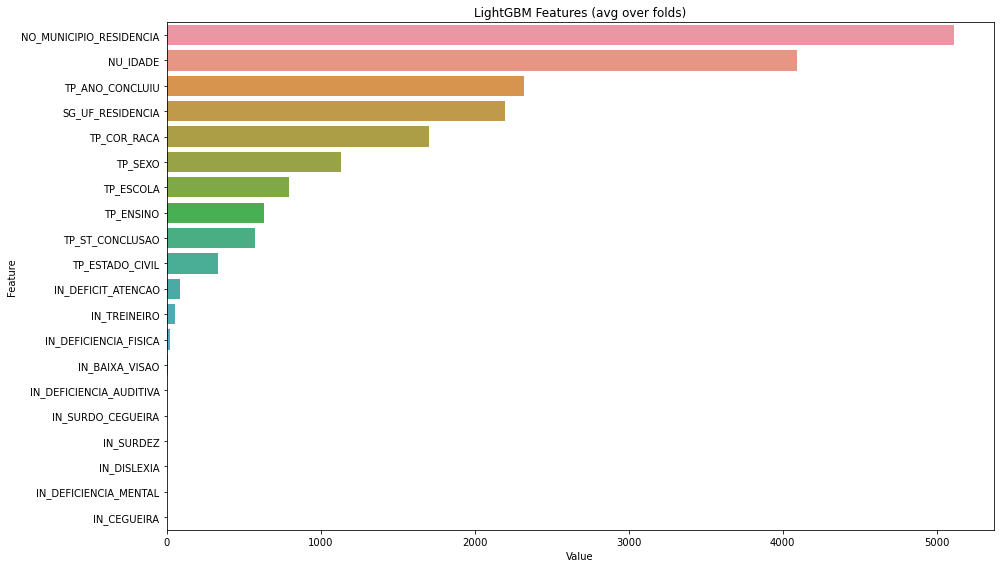

In [20]:
plot_feature_importance(natural_science_info[0])

In [46]:
#Error analysis
def error_analysis(error, y_cn):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

    sns.histplot(error, ax=ax1)
    sns.histplot(y_cn, ax=ax2, bins = 50)
    ax1.set_xlabel('Error for grades the grades', fontsize = 14)
    ax1.set_xlim([-300, 300])
    
    ax2.set_xlabel('Grade distribution', fontsize = 14)
    plt.show()

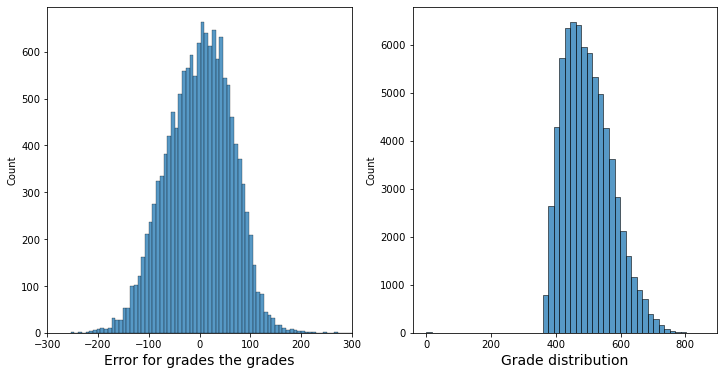

In [35]:
error = natural_science_info[2]
error_analysis(error, y_cn)

Model analysis for natural sciences...
 
Training the model using the folder number 1
RMSE over the validation set: 63.730
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 2
RMSE over the validation set: 64.590
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 3
RMSE over the validation set: 64.290
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 4
RMSE over the validation set: 64.670
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 5
RMSE over the validation set: 64.180
RMSE over the validation set compared to the std: 0.86
 
RMSE compared to the std: 0.87
Preparing feature importance...
 


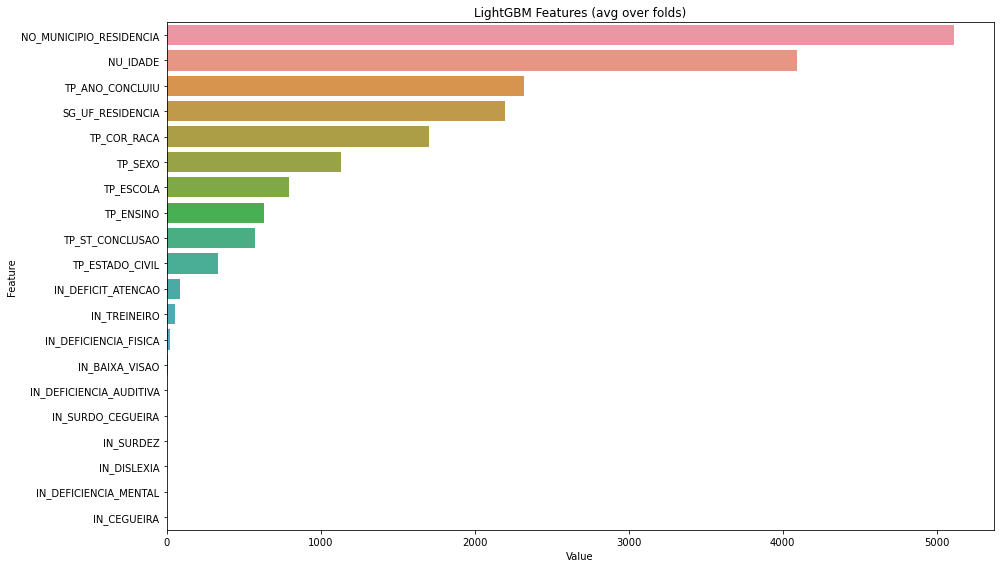

Preparing error analysis...
 


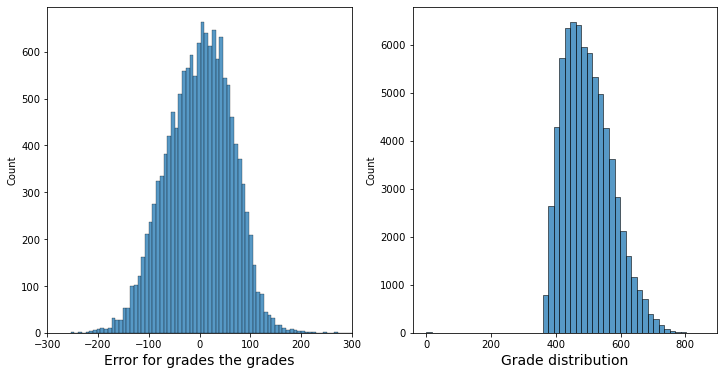

In [36]:
print ('Model analysis for natural sciences...')
print (' ')

natural_science_info = model_subject(y_cn)

print (' ')
print ('Preparing feature importance...')
print (' ')

plot_feature_importance(natural_science_info[0])

print ('Preparing error analysis...')
print (' ')

error_analysis(natural_science_info[2], y_cn)

Model analysis for human sciences...
 
Training the model using the folder number 1
RMSE over the validation set: 68.160
RMSE over the validation set compared to the std: 0.89
 
Training the model using the folder number 2
RMSE over the validation set: 69.260
RMSE over the validation set compared to the std: 0.89
 
Training the model using the folder number 3
RMSE over the validation set: 67.550
RMSE over the validation set compared to the std: 0.89
 
Training the model using the folder number 4
RMSE over the validation set: 68.840
RMSE over the validation set compared to the std: 0.89
 
Training the model using the folder number 5
RMSE over the validation set: 69.710
RMSE over the validation set compared to the std: 0.89
 
RMSE compared to the std: 0.89
 
Preparing feature importance...
 


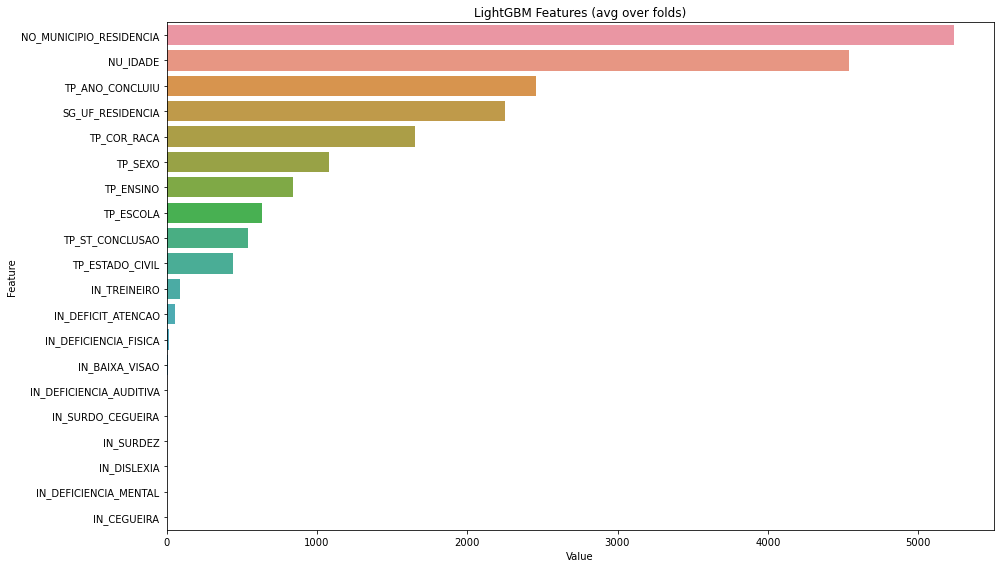

Preparing error analysis...
 


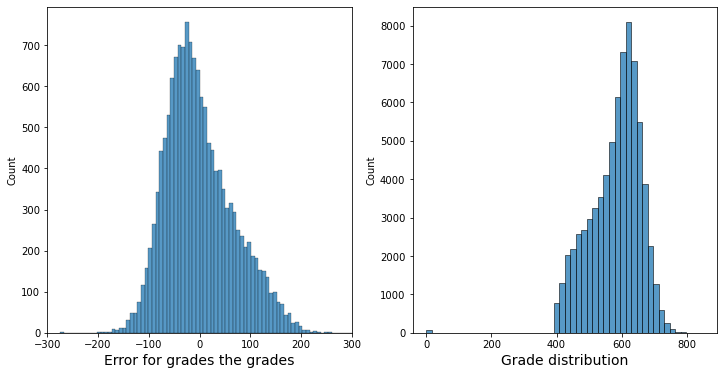

In [38]:
print ('Model analysis for human sciences...')
print (' ')

human_science_info = model_subject(y_ch)

print (' ')
print ('Preparing feature importance...')
print (' ')

plot_feature_importance(human_science_info[0])

print ('Preparing error analysis...')
print (' ')

error_analysis(human_science_info[2], y_ch)

Model analysis for portuguese and literature...
 
Training the model using the folder number 1
RMSE over the validation set: 60.770
RMSE over the validation set compared to the std: 0.87
 
Training the model using the folder number 2
RMSE over the validation set: 61.450
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 3
RMSE over the validation set: 60.710
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 4
RMSE over the validation set: 60.500
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 5
RMSE over the validation set: 61.380
RMSE over the validation set compared to the std: 0.85
 
RMSE compared to the std: 0.86
 
Preparing feature importance...
 


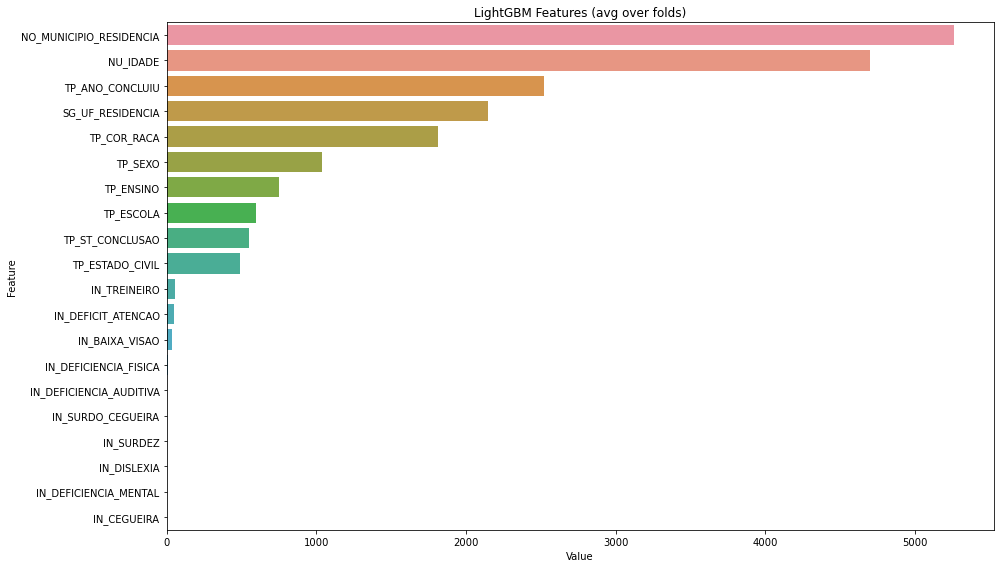

Preparing error analysis...
 


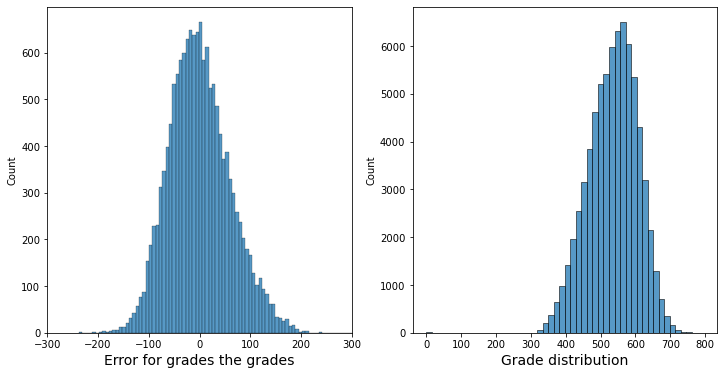

In [39]:
print ('Model analysis for portuguese and literature...')
print (' ')

port_lit_info = model_subject(y_lc)

print (' ')
print ('Preparing feature importance...')
print (' ')

plot_feature_importance(port_lit_info[0])

print ('Preparing error analysis...')
print (' ')

error_analysis(port_lit_info[2], y_lc)

Model analysis for math...
 
Training the model using the folder number 1
RMSE over the validation set: 86.420
RMSE over the validation set compared to the std: 0.84
 
Training the model using the folder number 2
RMSE over the validation set: 86.190
RMSE over the validation set compared to the std: 0.84
 
Training the model using the folder number 3
RMSE over the validation set: 86.790
RMSE over the validation set compared to the std: 0.85
 
Training the model using the folder number 4
RMSE over the validation set: 86.640
RMSE over the validation set compared to the std: 0.84
 
Training the model using the folder number 5
RMSE over the validation set: 86.410
RMSE over the validation set compared to the std: 0.84
 
RMSE compared to the std: 0.84
 
Preparing feature importance...
 


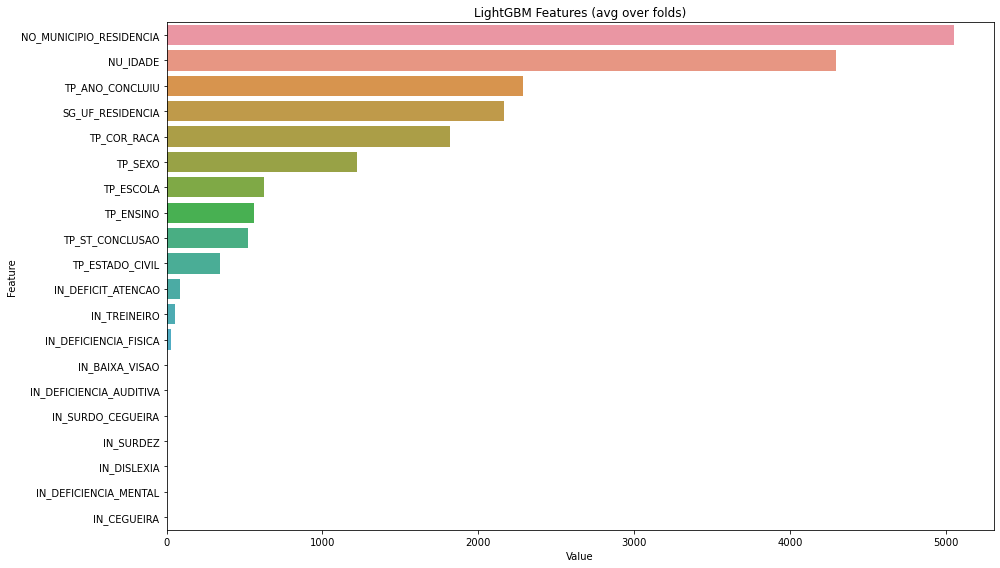

Preparing error analysis...
 


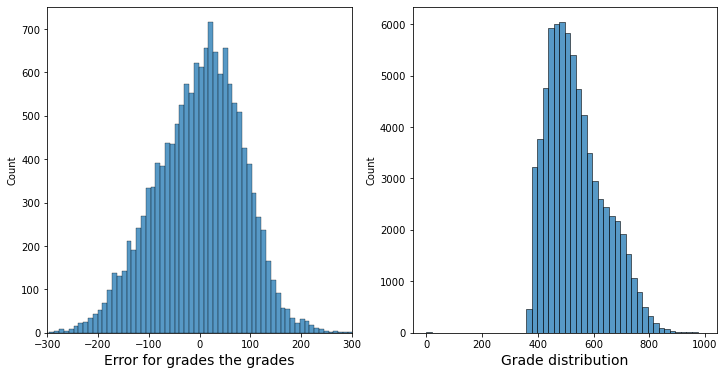

In [40]:
print ('Model analysis for math...')
print (' ')

math_info = model_subject(y_mt)

print (' ')
print ('Preparing feature importance...')
print (' ')

plot_feature_importance(math_info[0])

print ('Preparing error analysis...')
print (' ')

error_analysis(math_info[2], y_mt)

Model analysis for the essay...
 
Training the model using the folder number 1
RMSE over the validation set: 153.860
RMSE over the validation set compared to the std: 0.88
 
Training the model using the folder number 2
RMSE over the validation set: 156.190
RMSE over the validation set compared to the std: 0.89
 
Training the model using the folder number 3
RMSE over the validation set: 155.370
RMSE over the validation set compared to the std: 0.87
 
Training the model using the folder number 4
RMSE over the validation set: 154.020
RMSE over the validation set compared to the std: 0.87
 
Training the model using the folder number 5
RMSE over the validation set: 155.200
RMSE over the validation set compared to the std: 0.88
 
RMSE compared to the std: 0.88
 
Preparing feature importance...
 


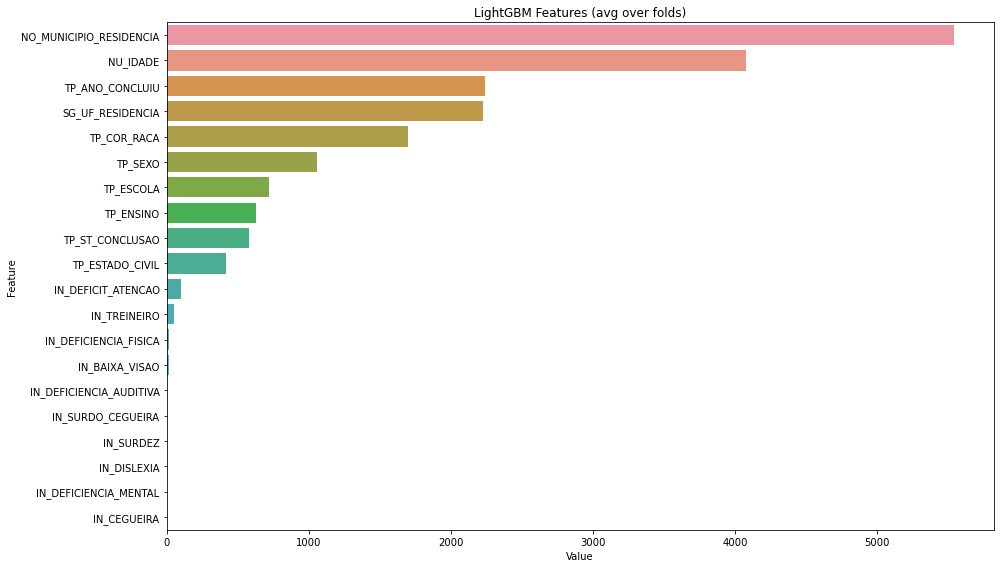

Preparing error analysis...
 


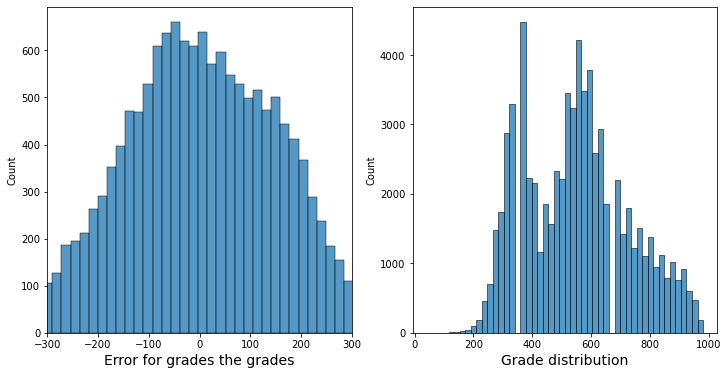

In [47]:
print ('Model analysis for the essay...')
print (' ')

essay_info = model_subject(y_redacao)

print (' ')
print ('Preparing feature importance...')
print (' ')

plot_feature_importance(essay_info[0])

print ('Preparing error analysis...')
print (' ')

error_analysis(essay_info[2], y_redacao)

## Brief discussion about the models prediction and the error analysis

Apart from the essay prediction, the rest of the predictions have their errors nicely
distributed in a Gaussian shape around zero. However, we observe that most of the grades
(except for portuguese and literature) are at least slightly skewed. That might be
compromising our model. There are a couple of points to further investigate. Since data
is unbalanced we can try to oversample part of of it try to balance it. A third option
would be to reconstruct at least the most relevant features. For example, one of the
questions which is relevant for all of the models is if the person has computer at
home or not. However, it has several options acoordingly to the number of computers
at home which might be necessary. So the first move that we are going to do is
check the relevant features and reformulate part of it.

In [ ]:
#Error analysis
def error_analysis(error, y_cn):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

    sns.histplot(error, ax=ax1)
    sns.histplot(y_cn, ax=ax2, bins = 50)
    ax1.set_xlabel('Error for grades the grades', fontsize = 14)
    ax1.set_xlim([-300, 300])
    
    ax2.set_xlabel('Grade distribution', fontsize = 14)
    plt.show()

In [32]:
X.head()

,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
1,São João dos Patos,MA,23.00,F,0.00,3,1,5,1,1.00,...,A,B,A,A,B,A,A,A,A,A
5,João Pessoa,PB,23.00,F,0.00,1,1,5,1,1.00,...,A,B,A,A,B,A,B,B,A,A
7,Parnaíba,PI,39.00,M,1.00,3,1,12,1,1.00,...,A,C,B,A,B,A,B,B,A,A
8,Fortaleza,CE,19.00,M,0.00,3,2,0,2,1.00,...,A,B,B,A,B,A,A,A,B,A
9,Cuiabá,MT,25.00,F,0.00,3,1,9,1,1.00,...,A,B,A,A,B,A,A,A,A,A


In [37]:
## Analyzing the range of grades distribution
## NU_NOTA_CN, NU_NOTA_CH, NU_NOTA_LC, NU_NOTA_MT

cols = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
names = ['Natural Sciences', 'Human Sciences', 'Portuguese and Literature', 'Mathematics', 'Essay']



def grade_range_dist(col, name):
    df = df2018[[col]].copy()
    df['range'] = 0

    df.loc[(df[col] > 0) & (df[col] <= 100),'range'] = 1
    df.loc[(df[col] > 100) & (df[col] <= 200),'range'] = 2
    df.loc[(df[col] > 200) & (df[col] <= 300),'range'] = 3
    df.loc[(df[col] > 300) & (df[col] <= 400),'range'] = 4
    df.loc[(df[col] > 400) & (df[col] <= 500),'range'] = 5
    df.loc[(df[col] > 500) & (df[col] <= 600),'range'] = 6
    df.loc[(df[col] > 600) & (df[col] <= 700),'range'] = 7
    df.loc[(df[col] > 700) & (df[col] <= 800),'range'] = 8
    df.loc[(df[col] > 800) & (df[col] <= 900),'range'] = 9
    df.loc[(df[col] > 900) & (df[col] <= 1000),'range'] = 10
    
    #print(df.head())
    
    sns.displot(df['range'], binwidth = 1, alpha = 0.3, color = 'blue')
    ax = plt.gca()
    fig = plt.gcf()
    fig.set_size_inches(5, 3)
    
    ax.set_xlabel('Range for grade distribution \nin {}'.format(name), fontsize = 12)
    ax.set_ylabel('Count', fontsize = 12)
    plt.show
    #return ax

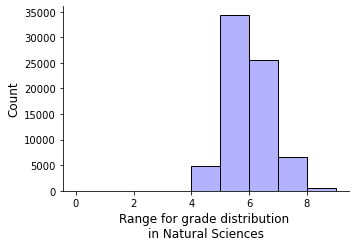

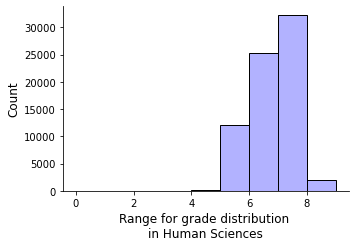

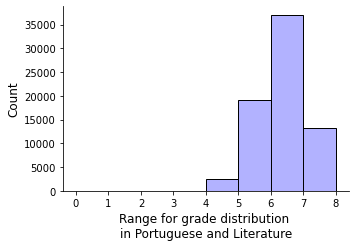

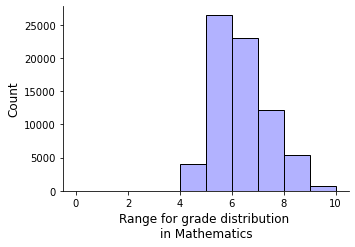

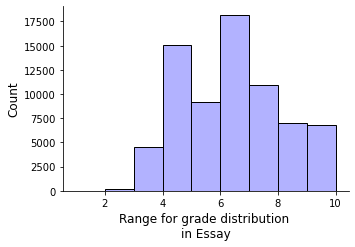

In [38]:
for i in range(len(cols)):
    grade_range_dist(cols[i], names[i])

#grade_range_dist('NU_NOTA_CN', 'Natural Sciences')

#df2018[['NU_NOTA_CN']]

## Hyperparameter tunning

In [60]:
#y_cn y_ch y_lc y_mt y_redacao Let's round it to multiple of 50 

#X_train, X_test, y_train, y_test = train_test_split(X, y_cn, test_size = 0.2, random_state = 0, stratify = y_cn)    

y_cn = 50*np.around(y_cn/50)
y_ch = 50*np.around(y_ch/50)
y_mt = 50*np.around(y_mt/50)
y_lc = 50*np.around(y_lc/50)
y_redacao = 50*np.around(y_redacao/50)

X_train, X_test, y_train, y_test = train_test_split(X, y_cn, test_size = 0.2, random_state = 0, stratify = y_cn)

In [ ]:
params = {'is_unbalance' : True,
          'boosting_type' : 'gbdt',
          'objective' : 'regression',
          'metric' : 'l2',#'l1',
          'num_iterations' : 2000,
          'verbosity' : -1,
          'num_leaves': 32,
          'learning_rate': 0.05
          #'lambda_l2': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
          #'lambda_l1': [1e-4, 1e-3, 1e-2, 1e-1, 1]
         }

kf = KFold(n_splits = 5, shuffle = True, random_state = 0)
    

rmse_scores = []
i = 1

for max_depth_value in range(3, 7):
    for train_index, test_index in kf.split(X_train, y_train):
        print('Training the model using the folder number {}'.format(i))
        X_kfold_train, X_kfold_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_kfold_train, y_kfold_test = y_train[train_index], y_train[test_index]
    
        model_lgbm = lgb.LGBMRegressor(**params, max_depth = max_depth_value)
        model_lgbm.fit(X_kfold_train, y_kfold_train,
                       eval_set = [(X_kfold_train, y_kfold_train), (X_kfold_test, y_kfold_test)],
                       early_stopping_rounds = int(params['num_iterations']), verbose = False)
    
        y_kfold_pred = model_lgbm.predict(X_kfold_test)
        rmse = np.sqrt(mean_squared_error(y_kfold_test, y_kfold_pred))
        rmse_scores.append(rmse)
        
        rmse_std_comparison = round(rmse/y_kfold_test.std(), 2)
    
        print('RMSE over the validation set: {:.3f}'.format(round(rmse, 2)))
        print('RMSE over the validation set compared to the std: {}'.format(rmse_std_comparison))
        print(' ')
    
        i += 1
    
    y_pred = model_lgbm.predict(X_test)
    error = pd.Series(y_pred) - y_test
        
    rmse_std_comp = round(np.sqrt(mean_squared_error(y_pred, y_test))/y_test.std(), 2)
    
    print('RMSE compared to the std: {}'.format(rmse_std_comp))

In [64]:
def model_subject(y_cn, num_leaves = 32, learning_rate = 0.05, max_depth = 6):

    params = {'is_unbalance' : True,
              'boosting_type' : 'gbdt',
              'objective' : 'regression',
              'metric' : 'l2',#'l1',
              'num_iterations' : 2000,
              'verbosity' : -1,
              'num_leaves': num_leaves,
              'learning_rate': learning_rate,
              'max_depth': max_depth
              #'lambda_l2': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              #'lambda_l1': [1e-4, 1e-3, 1e-2, 1e-1, 1]
             }

    X_train, X_test, y_train, y_test = train_test_split(X, y_cn, test_size = 0.2, random_state = 0)

    kf = KFold(n_splits = 5, shuffle = True, random_state = 0)
    

    rmse_scores = []
    i = 1

    for train_index, test_index in kf.split(X_train, y_train):
        print('Training the model using the folder number {}'.format(i))
        
        X_kfold_train, X_kfold_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_kfold_train, y_kfold_test = y_train[train_index], y_train[test_index]
        
        model_lgbm = lgb.LGBMRegressor(**params)
        model_lgbm.fit(X_kfold_train, y_kfold_train,
                       eval_set = [(X_kfold_train, y_kfold_train), (X_kfold_test, y_kfold_test)],
                      early_stopping_rounds = int(params['num_iterations']), verbose = False)
    
        y_kfold_pred = model_lgbm.predict(X_kfold_test)
        rmse = np.sqrt(mean_squared_error(y_kfold_test, y_kfold_pred))
        rmse_scores.append(rmse)
        
        rmse_std_comparison = round(rmse/y_kfold_test.std(), 2)
        
        print('RMSE over the validation set: {:.3f}'.format(round(rmse, 2)))
        print('RMSE over the validation set compared to the std: {}'.format(rmse_std_comparison))
        print(' ')
    
        i += 1
    
    y_pred = model_lgbm.predict(X_test)
    error = pd.Series(y_pred) - y_test
    
    rmse_std_comp = round(np.sqrt(mean_squared_error(y_pred, y_test))/y_test.std(), 2)
    
    print('RMSE compared to the std for {} max_depth: {}'.format(max_depth, rmse_std_comp))
    
    return rmse_std_comp

In [65]:
max_depth_dict = dict()

for max_depth_value in range(3, 7):
    print (' ')
    print (' ')
    rmse = model_subject(y_cn, max_depth = max_depth_value)
    max_depth_dict[max_depth_value] = rmse
    print (' ')
    print (' ')

 
 
Training the model using the folder number 1
RMSE over the validation set: 65.320
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 2
RMSE over the validation set: 65.560
RMSE over the validation set compared to the std: 0.87
 
Training the model using the folder number 3
RMSE over the validation set: 64.950
RMSE over the validation set compared to the std: 0.85
 
Training the model using the folder number 4
RMSE over the validation set: 64.750
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 5
RMSE over the validation set: 65.030
RMSE over the validation set compared to the std: 0.86
 
RMSE compared to the std for 3 max_depth: 0.86
 
 
 
 
Training the model using the folder number 1
RMSE over the validation set: 65.530
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 2
RMSE over the validation set: 65.870
RMSE over the validation 